In [20]:
import numpy as np
import torchio as tio
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import SimpleITK as sitk
sitk.ProcessObject_SetGlobalWarningDisplay(False) # pour virer les warnings


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

#### Fonctions système

In [21]:
def pred_to_submission(y_pred): # Petit code rapide pour compléter le csv de submission
    submission = pd.DataFrame({'Id': range(101, 151), 'Category': [int(y) for y in y_pred]})
    submission.to_csv("submission.csv", index=False)

#### Affichage du dataset

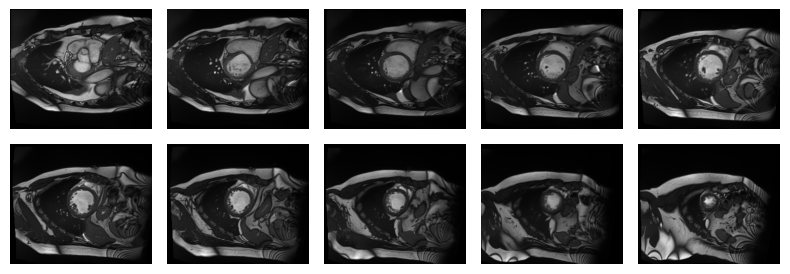

In [22]:
image=tio.ScalarImage("Dataset/Train/001/001_ED.nii")
image=np.squeeze(image)

fig, axs = plt.subplots(2, 5, figsize=(8, 3))

# Afficher les 10 slices
for i, ax in enumerate(axs.flat):
    ax.imshow(image[:, :, i], cmap='gray')
    ax.axis('off')  # Désactiver les axes

plt.tight_layout()
plt.show()

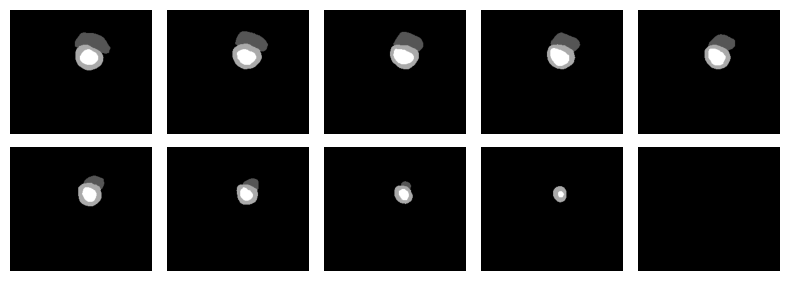

In [50]:
image=tio.ScalarImage("Dataset/Train/028/028_ED_seg.nii")
image=np.squeeze(image)

fig, axs = plt.subplots(2, 5, figsize=(8, 3))

# Afficher les 10 slices
for i, ax in enumerate(axs.flat):
    ax.imshow(image[:, :, i], cmap='gray')
    ax.axis('off')  # Désactiver les axes

plt.tight_layout()
plt.show()

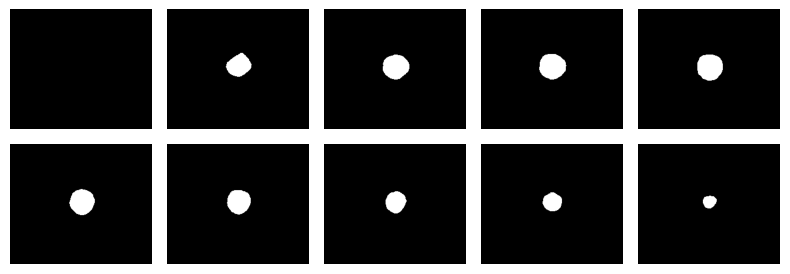

In [65]:
image=tio.ScalarImage("Dataset/Train/001/001_ED_seg.nii")
image=np.squeeze(image)
myocarde=((image==3) * 255).astype(np.uint8)  # juste le myocarde
# 3=vg, 2=myocarde, 3=VR

fig, axs = plt.subplots(2, 5, figsize=(8, 3))

# Afficher les 10 slices
for i, ax in enumerate(axs.flat):
    ax.imshow(myocarde[:, :, i], cmap='gray')
    ax.axis('off')  # Désactiver les axes

plt.tight_layout()
plt.show()

IndexError: index 8 is out of bounds for axis 2 with size 8

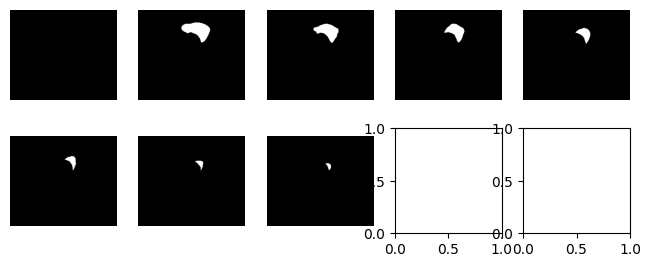

In [62]:
image=tio.ScalarImage("Dataset/Test/101/101_ED_seg.nii")
image=np.squeeze(image)
myocarde=((image==1) * 255).astype(np.uint8)  # juste le myocarde
# 3=vg, 2=myocarde, 3=VR

fig, axs = plt.subplots(2, 5, figsize=(8, 3))

# Afficher les 10 slices
for i, ax in enumerate(axs.flat):
    ax.imshow(myocarde[:, :, i], cmap='gray')
    ax.axis('off')  # Désactiver les axes

plt.tight_layout()
plt.show()

## Création des jeux de données

### On commence par le training set

In [25]:
n=100 # number of patients in the traning set
p=1+4+4   # number of predictors

In [ ]:
data = np.genfromtxt('Dataset/metaDataTrain.csv', delimiter=',')[1::]


train=np.zeros((n,p+1))

train[:,0]=data[:,1]   # classe du patient
train[:,1]=data[:,3]/((data[:,2]/100)**2) # First feature will be patient's IMC

print(train[:3])

[[ 2.         28.0600189   0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 2.         27.34375     0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 2.         28.28282828  0.          0.          0.          0.
   0.          0.          0.          0.        ]]


### Puis le test set

In [27]:
dataTest = np.genfromtxt('Dataset/metaDataTest.csv', delimiter=',')[1::]

test=np.zeros((int(n/2),p+1))

test[:,0]=None  # classe du patient
test[:,1]=dataTest[:,2]/((dataTest[:,1]/100)**2) # IMC

print(test[:3])

[[        nan 24.22145329  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [        nan 22.86236854  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [        nan 30.3871439   0.          0.          0.          0.
   0.          0.          0.          0.        ]]


## Features

## 1. computeLVMthickness function

In [ ]:
'''image=tio.ScalarImage("Dataset/Train/001/001_ED_seg.nii")
image=np.squeeze(image)
myocarde=((image==2) * 255).astype(np.uint8) # juste le myocarde'''

def computeLVMthickness(myocarde): # must be gt
    scale = 5  
    max_thickness_per_slice = []
    min_thickness_per_slice = []
    mean_thickness_per_slice = []
    all_thicknesses = []

    for z in range(myocarde.shape[2]):  
        resized = cv2.resize(myocarde[:, :, z], (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
        binary = (resized > 0).astype(np.uint8) * 255
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        if len(contours) > 0:
            contour = max(contours, key=cv2.contourArea)
            skeleton = cv2.ximgproc.thinning(binary)
            distances = [cv2.pointPolygonTest(contour, (int(pt[1]), int(pt[0])), True) for pt in np.argwhere(skeleton > 0)]
            thicknesses = [2 * abs(d) / scale for d in distances]  

            if thicknesses:
                max_thickness_per_slice.append(max(thicknesses))
                min_thickness_per_slice.append(min(thicknesses))
                mean_thickness_per_slice.append(sum(thicknesses) / len(thicknesses))
                all_thicknesses.extend(thicknesses)

    if all_thicknesses:
        mean_max_thickness = sum(max_thickness_per_slice) / len(max_thickness_per_slice)
        mean_min_thickness = sum(min_thickness_per_slice) / len(min_thickness_per_slice)
        mean_thickness = sum(mean_thickness_per_slice) / len(mean_thickness_per_slice)
        
        std_thickness = (sum((t - mean_thickness) ** 2 for t in all_thicknesses) / len(all_thicknesses)) ** 0.5

        return mean_min_thickness, mean_max_thickness, mean_thickness, std_thickness


computeLVMthickness(myocarde)   # mean_min_thickness, mean_max_thickness, mean_thickness, std_thickness


### Compute thickness for both sets

In [ ]:
#training set
for i in range(1,101):

    index=str(i).zfill(3)

    #Diastole
    ED_seg=tio.ScalarImage("Dataset/Train/"+index+"/"+index+"_ED_seg.nii")
    ED_seg=np.squeeze(ED_seg)
    myocarde=((ED_seg==2) * 255).astype(np.uint8) # on conserve juste le myocarde
    train[i-1,2:6]=np.array(computeLVMthickness(myocarde))

    #Systole
    ES_seg=tio.ScalarImage("Dataset/Train/"+index+"/"+index+"_ES_seg.nii")
    ES_seg=np.squeeze(ES_seg)
    myocarde=((ES_seg==2) * 255).astype(np.uint8) # on conserve juste le myocarde
    train[i-1,6:10]=np.array(computeLVMthickness(myocarde))


# test set
for i in range(101,151):

    index=str(i)

    # Diastole
    ED_seg=tio.ScalarImage("Dataset/Test/"+index+"/"+index+"_ED_seg.nii")
    ED_seg=np.squeeze(ED_seg)
    myocarde=((ED_seg==2) * 255).astype(np.uint8) # on conserve juste le myocarde
    test[i-100-1,2:6]=np.array(computeLVMthickness(myocarde))

    # Systole
    ES_seg=tio.ScalarImage("Dataset/Test/"+index+"/"+index+"_ES_seg.nii")
    ES_seg=np.squeeze(ES_seg)
    myocarde=((ES_seg==2) * 255).astype(np.uint8) # on conserve juste le myocarde
    test[i-100-1,6:10]=np.array(computeLVMthickness(myocarde))

[[ 2.         28.0600189   2.95069978  8.17108133  5.45189285  1.02553095
   4.27391428 10.10202216  7.083667    1.26224767]
 [ 2.         27.34375     2.9476535   9.9519277   6.03283259  1.57509484
   3.73089586 11.75985533  8.0971531   1.99480569]
 [ 2.         28.28282828  3.51475367  8.73981373  6.18204015  1.25333897
   3.51108104 10.91585521  6.80564401  1.60472572]
 [ 2.         18.19548277  3.71214034  8.66797606  6.26256966  1.2930572
   3.83401372 10.42620942  6.94655752  1.64226706]
 [ 2.         28.28282828  3.70438053  9.19036811  6.8046403   1.33607195
   4.14980543 11.49337973  8.35143521  2.04272459]
 [ 2.         21.60493827  2.5181052   7.79429366  5.13126259  1.14377879
   2.71072657  7.97809755  5.15102512  1.28262622]
 [ 2.         35.75127802  2.56486218  7.33732693  4.80862593  1.10709134
   2.4948256   7.96545653  4.97458343  1.32418613]
 [ 2.         30.86419753  2.68785471  8.02564096  5.22555731  1.18931837
   3.22634868 11.17525275  6.4492121   1.68067557]
 

## 2. Ejection fraction RV

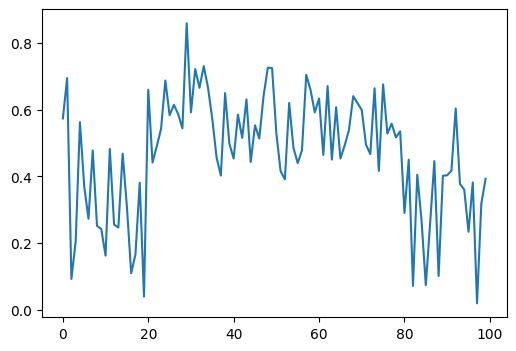

In [ ]:
def computeEjectionfraction(i,set): # == 3     set = Train ou Test

    index=str(i).zfill(3)

    # Compute ED volume
    image=tio.ScalarImage("Dataset/"+set+"/"+index+"/"+index+"_ED_seg.nii")
    image=np.squeeze(image)
    RV=((image==1) * 255).astype(np.uint8) # juste le RV

    RVarea=[]
    for z in range(RV.shape[2]):  
        RVarea.append(np.count_nonzero(RV[:, :, z]))

    EDV=np.mean(RVarea)


    # Compute ES volume
    image=tio.ScalarImage("Dataset/"+set+"/"+index+"/"+index+"_ES_seg.nii")
    image=np.squeeze(image)
    RV=((image==1) * 255).astype(np.uint8) # juste le RV

    RVarea=[]
    for z in range(RV.shape[2]):  
        RVarea.append(np.count_nonzero(RV[:, :, z]))

    ESV=np.mean(RVarea)


    SV = EDV - ESV  # Stroke Volume
    EF = SV / EDV

    return EF



ef=[]
for i in range(1,101):
    ef.append(computeEjectionfraction(i,"Train"))

plt.figure(figsize=(6,4))  # this graph shows that ejection fraction may be used as a classification feature.
plt.plot(ef)
plt.show()

### Compute RV ejection fraction for both sets

In [70]:
print("To do")

To do


## 3. Segmentation of the LV
While we have acess to the segmentation of the LV in the training dataset, we are not provided with this segmentation in the Test dataset, which means we need to be able to compute it. Fortunately we have acess to the myocardium which allows us to obtain the LV segmentation.

## Prediction pipeline

We will be using RandomForests as this is what provides better results.

            1         2         3         4         5         6          7  \
0   28.060019  2.950700  8.171081  5.451893  1.025531  4.273914  10.102022   
1   27.343750  2.947653  9.951928  6.032833  1.575095  3.730896  11.759855   
2   28.282828  3.514754  8.739814  6.182040  1.253339  3.511081  10.915855   
3   18.195483  3.712140  8.667976  6.262570  1.293057  3.834014  10.426209   
4   28.282828  3.704381  9.190368  6.804640  1.336072  4.149805  11.493380   
..        ...       ...       ...       ...       ...       ...        ...   
95  21.967858  2.396917  7.418190  4.823150  1.266968  3.021956   9.030836   
96  23.449341  2.950945  7.826807  5.201721  1.541709  3.945570  10.727459   
97  17.928215  2.756253  9.724114  7.050748  1.888617  4.979939  13.083115   
98  24.691358  2.479799  6.161256  4.235382  0.836194  3.215248   7.570139   
99  23.140496  3.458881  8.276268  5.826990  1.359848  5.618175  11.387602   

           8         9  
0   7.083667  1.262248  
1   8.097153 

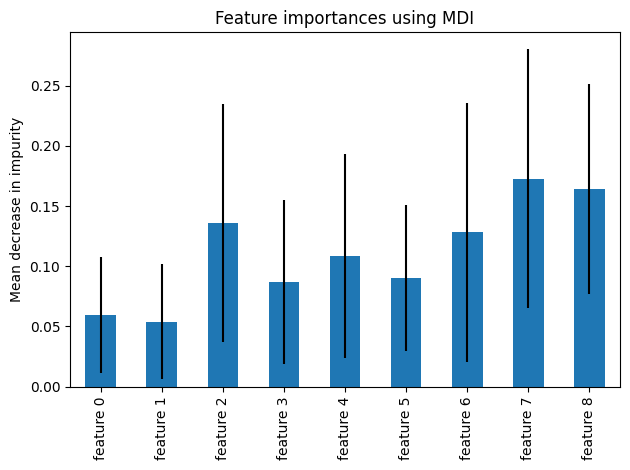

In [ ]:
df = pd.DataFrame(train)   # on repasse notre array numpy sous forme de dataframe pour pouvoir feed le classifyier
X_train = df.drop(0, axis=1) # on sépare les classes dans un dataframe distinct
y_train = df[0]


dft = pd.DataFrame(test)
X_test=dft.drop(0,axis=1)




clf = RandomForestClassifier(n_estimators=1000) # 1000 arbres

clf.fit(X_train, y_train)

y_pred=clf.predict(X_test)

print(y_pred)



# Plot l'importance des features

importances = clf.feature_importances_
feature_names = [f"feature {i+1}" for i in range(p)]
forest_importances = pd.Series(importances, index=feature_names)
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()



#pred_to_submission(y_pred)

In [43]:
# petits essais de cross validation
from sklearn.model_selection import cross_val_score
c=cross_val_score(clf, X_train, y_train, cv=5)
print(np.mean(c),np.var(c))

0.72 0.0086
